# Project : STATIC ANALYSIS

>[Project : Malware Classifier for APK Files](#scrollTo=S8Ei4VVDAloM)

>>>[Part 1: Importing Necessary Modules](#scrollTo=yfdPvf1UNhRD)

>>>[Part 2: Data Description and Project Objective](#scrollTo=ofew9fM1pJND)

>>>[Part 3: Analysis of the Dataset](#scrollTo=cK6mAsv32Xhf)

>>>[Part 4: Data Cleaning](#scrollTo=9nsIjxUj6YmQ)

>>>[Part 5: Feature Engineering](#scrollTo=_SzokkN5CvzA)

>>>[Part 6: Preprocessing](#scrollTo=0NtGmDcdEJmJ)

>>>[Part 7: Modeling and Evaluation](#scrollTo=jyBeBq9lCyvo)

>>>[Part 8: XAI](#scrollTo=14sb4CSxK4IW)



### Part 1: Importing Necessary Modules and Parse Logs
---



In [1]:
import os 
import json 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
import lime
import lime.lime_tabular

### Part 2: Data Description and Project Objective  
---

 1. **Dataset**: https://www.kaggle.com/datasets/shashwatwork/android-malware-dataset-for-machine-learning
 2. **Data Description**: Dataset consisting of feature vectors of 215 attributes extracted from 15,036 applications (5,560 malware apps from Drebin project and 9,476 benign apps).
 3. **Objective**: Conduct a static analysis of Android APK files utilizing supervised machine learning techniques, with the goal of classifying the samples as either benign or malicious. The analysis is performed using the Drebin dataset, which provides a comprehensive collection of features for Android malware detection. This notebook illustrates the steps taken to solve this ML classification problem and ultimatley aims to enhance malware detection capabilities through the application of machine learning algorithms, enabling accurate classification based on static characteristics extracted from APK files in support of the white rAbbIt hybrid analysis tool.


In [2]:
df = pd.read_csv('drebin-215-dataset-5560malware-9476-benign.csv')
feature_categories = pd.read_csv('dataset-features-categories.csv', header=None, names=["Feature", "Category"])

C:\Users\caela\AppData\Local\Temp\ipykernel_20896\3512757352.py:1: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('drebin-215-dataset-5560malware-9476-benign.csv')


### Part 3: Analysis of the Dataset
---

 1. Shape of the dataframe
 2. Display all features and its corresponding attributes or properties related to Android applications
 3. Mapping of benign (B) and malicious (S) samples
 4. Determine if the dataset is balanced or imbalanced
 5. Display the first few rows of the dataset
 6. Validate features that are supposed to be binary and handle value types
 7. Analyze missing values 



#### 1. Shape of the dataframe

In [3]:
#Get the shape of the dataframe and output results as a table
print("\033[1mShape of the Dataset:\033[0m")
sample_shape = df.shape[0]
feature_shape = df.shape[1]
shape_data = [[sample_shape, feature_shape]]
overview_shape_df = pd.DataFrame(shape_data, columns=['Samples', 'Features'])
blankIndex=[''] * len(overview_shape_df)
overview_shape_df.index=blankIndex
display(overview_shape_df)


Shape of the Dataset:


,Samples,Features
,15036,216


#### 2. Display all features and its corresponding attributes or properties related to Android applications

In [4]:
#Display all features and its corresponding attributes or properties related to Android applications
display(feature_categories)

#Unique list of attributes or properties related to Android applications
print(feature_categories['Category'].unique())

,Feature,Category
0,transact,API call signature
1,onServiceConnected,API call signature
2,bindService,API call signature
3,attachInterface,API call signature
4,ServiceConnection,API call signature
...,...,...
211,ACCESS_FINE_LOCATION,Manifest Permission
212,SET_WALLPAPER_HINTS,Manifest Permission
213,SET_PREFERRED_APPLICATIONS,Manifest Permission
214,WRITE_SECURE_SETTINGS,Manifest Permission


['API call signature' 'Manifest Permission' 'Intent' 'Commands signature'
 'B=Benign; S=Malware']


In [5]:
# Group features by category
category_groups = feature_categories.groupby('Category')['Feature'].apply(list).to_dict()

# Print features by category
for category, features in category_groups.items():
    print(f"Category: {category}")
    print(f"Features: {features}\n")

Category: API call signature
Features: ['transact', 'onServiceConnected', 'bindService', 'attachInterface', 'ServiceConnection', 'android.os.Binder', 'Ljava.lang.Class.getCanonicalName', 'Ljava.lang.Class.getMethods', 'Ljava.lang.Class.cast', 'Ljava.net.URLDecoder', 'android.content.pm.Signature', 'android.telephony.SmsManager', 'getBinder', 'ClassLoader', 'Landroid.content.Context.registerReceiver', 'Ljava.lang.Class.getField', 'Landroid.content.Context.unregisterReceiver', 'Ljava.lang.Class.getDeclaredField', 'getCallingUid', 'Ljavax.crypto.spec.SecretKeySpec', 'android.content.pm.PackageInfo', 'KeySpec', 'TelephonyManager.getLine1Number', 'DexClassLoader', 'HttpGet.init', 'SecretKey', 'Ljava.lang.Class.getMethod', 'System.loadLibrary', 'android.intent.action.SEND', 'Ljavax.crypto.Cipher', 'android.telephony.gsm.SmsManager', 'TelephonyManager.getSubscriberId', 'Runtime.getRuntime', 'Ljava.lang.Object.getClass', 'Ljava.lang.Class.forName', 'Binder', 'IBinder', 'android.os.IBinder', 'c

API Call Signature: Specific details about method calls in an app.

Manifest Permission: Permissions declared in the manifest file to access restricted features.

Intent: A messaging object for inter-component communication.

Commands Signature: Method signatures for custom command invocations.

#### 3. Mapping of benign (B) and malicious (S) samples

In [6]:
#Map 'B' to 0 (Benign) and 'S' to 1 (Malware)
df['class'] = df['class'].map({'B': 0, 'S': 1})

##### 4. Determine if the dataset is balanced or imbalanced

,Label,Classification,Count
,0,Benign,9476
,1,Malware,5560


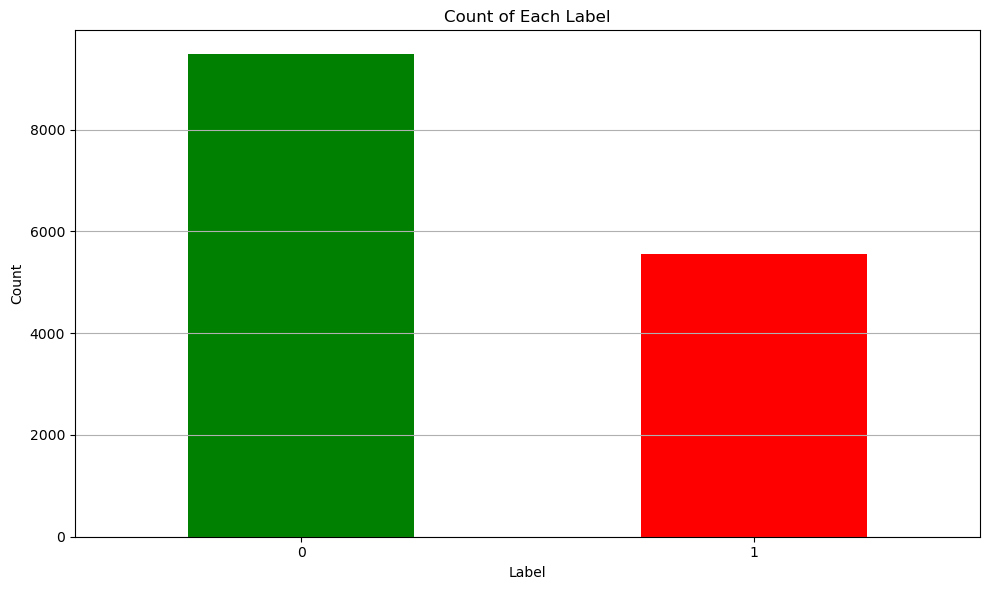

In [7]:
#Count the occurrences of each label
label_counts = df['class'].value_counts()
label_counts_df = pd.DataFrame(label_counts).reset_index()
label_counts_df.columns = ['Label', 'Count']
blankIndex = [''] * len(label_counts_df)
label_counts_df.index = blankIndex
label_counts_df.insert(1, "Classification", ["Benign", "Malware"])
display(label_counts_df)

#Plot the count of each label
plt.figure(figsize=(10, 6))
bars = label_counts.plot(kind='bar', color=['green', 'red'])

#Add a title and labels
plt.title('Count of Each Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### 5. Display the first few rows of the dataset

In [8]:
# Display the first few rows of the dataset
print("\033[1mFirst few rows of the dataset:\033[0m")
display(df)

First few rows of the dataset:


,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15031,1,1,1,1,1,1,0,1,1,1,...,0,0,0,1,1,0,0,0,0,0
15032,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
15033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
15034,1,1,1,1,1,1,0,1,1,1,...,1,0,0,1,1,1,0,0,0,0


REMARK: The first few rows provide a quick look at the structure and contents of the dataset. This helped me understand what kind of data I'm dealing with, the column names, and the first few values. In this case, the dataset contains various features related to API calls and permissions.

#### 6. Validate features that are supposed to be binary and handle value types

In [9]:
#Print dataframe shape
print(f"\033[1mDataframe Shape:\033[0m\n{df.shape}")

#Get features that have either interger or float data types 
features_type_num = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\033[1mTotal Features that are either interger or float data types:\033[0m\n{len(features_type_num)}")

#Get features that have object data types  
list_of_features_with_categories = df.select_dtypes(include=['object']).columns.tolist()
print(f"\033[1mFeatures that have object data types:\033[0m\n{list_of_features_with_categories}")

#Function to check if a column is binary to ensure that the data indicates the presence 
#or absence of specific API calls and permissions.
def is_binary(col):
    return sorted(df[col].unique()) == [0, 1]

#Apply the function is_binary to all columns except the features that have an object data type
binary_columns = [col for col in df.columns if col not in list_of_features_with_categories and is_binary(col)]

#Display the binary columns
print(f"\033[1mBinary Columns:\033[0m\n{len(binary_columns)}")

#Check unique values in the non-binary column
unique_values = df['TelephonyManager.getSimCountryIso'].unique()
print(f"\033[1mUnique Values in 'TelephonyManager.getSimCountryIso':\033[0m\n{unique_values}")

#Get the count of the number of "?" found in the 'TelephonyManager.getSimCountryIso' column
print(df['TelephonyManager.getSimCountryIso'].value_counts())

#Print statement shows there is both integer and string  representations along with the "?" object
#Replace '?' with NaN
df['TelephonyManager.getSimCountryIso'] = df['TelephonyManager.getSimCountryIso'].replace('?', np.nan)

# Drop rows with NaN in 'TelephonyManager.getSimCountryIso' column (if desired)
df.dropna(subset=['TelephonyManager.getSimCountryIso'], inplace=True)

#Convert the column to numeric (this will turn NaN into NaN and strings into numbers)
df['TelephonyManager.getSimCountryIso'] = df['TelephonyManager.getSimCountryIso'].astype('int')

#Verify changes
print(df['TelephonyManager.getSimCountryIso'].value_counts())

#Print dataframe shape
print(f"\033[1mNew Dataframe Shape:\033[0m\n{df.shape}")

#Count the occurrences of each label
label_counts = df['class'].value_counts()
label_counts_df = pd.DataFrame(label_counts).reset_index()
label_counts_df.columns = ['Label', 'Count']
blankIndex = [''] * len(label_counts_df)
label_counts_df.index = blankIndex
label_counts_df.insert(1, "Classification", ["Benign", "Malware"])
display(label_counts_df)

Dataframe Shape:
(15036, 216)
Total Features that are either interger or float data types:
215
Features that have object data types:
['TelephonyManager.getSimCountryIso']
Binary Columns:
215
Unique Values in 'TelephonyManager.getSimCountryIso':
['0' '1' '?' 1 0]
TelephonyManager.getSimCountryIso
0    6994
0    5514
1    1330
1    1193
?       5
Name: count, dtype: int64
TelephonyManager.getSimCountryIso
0    12508
1     2523
Name: count, dtype: int64
New Dataframe Shape:
(15031, 216)


,Label,Classification,Count
,0,Benign,9476
,1,Malware,5555


Verify that the values for each feature indicates the presence or absence of a specific API call and/or permission

#### 7. Analyze missing values 

In [10]:
#Check for missing values in the dataset
missing_values = df.isnull().sum()

# Verify if all values are 0
if (missing_values == 0).all():
    print("\033[1mAll features have 0 missing values.\033[0m")
else:
    print("\033[1mSome features have missing values:\033[0m")
    print(missing_values[missing_values > 0])

All features have 0 missing values.


In [11]:
df.to_csv('cleaned_preprocessed_drebin.csv', index=False)  

REMARK: Missing values count provides information about how many missing or null values are present in each column. This is crucial for data cleaning and preprocessing steps. 

### Part 6: Preprocessing
---

 1. Separate the labels from the features
 2. Train, Dev, Test Split
 3. Handle imbalanced training data


#### 1. Seperate the lables from the features 

In [12]:
#Separate features and labels
X = df.drop(columns=['class'])
y = df['class']

print('Data Shape: ', X.shape)
print('Label Shape:', y.shape)

Data Shape:  (15031, 215)
Label Shape: (15031,)


#### 2. Train, Dev, Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### 3. Handle imbalanced training data

In [14]:
smote = SMOTE()
#Resample the dataset
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Training data shape: {X_train_resampled.shape}, {y_train_resampled.value_counts()}")
print(f"Testing data shape: {X_test.shape}, {y_test.value_counts()}")

Training data shape: (15160, 215), class
0    7580
1    7580
Name: count, dtype: int64
Testing data shape: (3007, 215), class
0    1896
1    1111
Name: count, dtype: int64


Balance the dataset using SMOTE (Synthetic Minority Over-sampling Technique) to ensure that the model does not favor the majority class (benign)

### Part 7: Modeling and Evaluation

---

 1. Modeling and Evaluation of imbalanced dataset
 2. Modeling and Evaluation using SMOTE 
 
 Selected Models: Logistic Regression, KNN, Random Forest, SVM, Gradient Boosting

 Performance Assesment: Accuracy, Precission, Recall, F1 Score, ROC AUC, Confusion Matrix)
 
 3. Classification report of best model
 4. Detect overfitting using the ROC AUC
 5. Feature Impotance (Random Forest)
 


#### 1. Modeling and Evaluation of imbalanced dataset

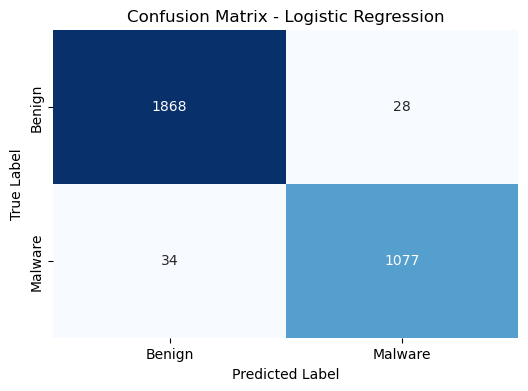

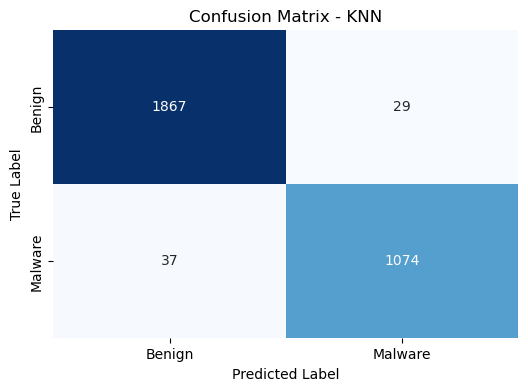

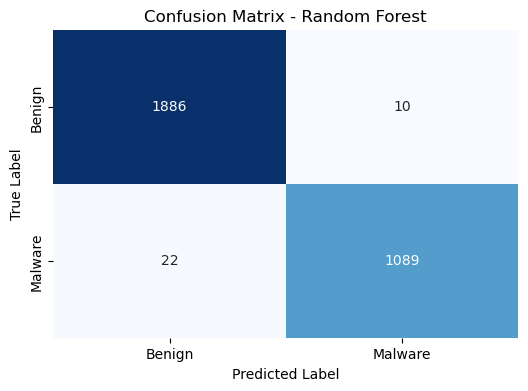

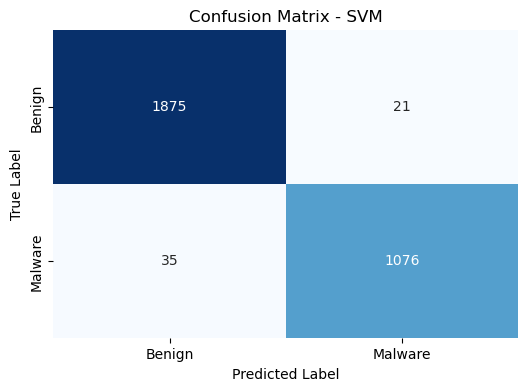

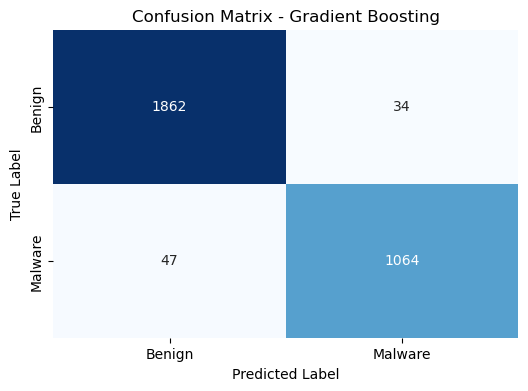

Results without SMOTE:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.979381   0.974661  0.969397  0.972022  0.996581
1                  KNN  0.978051   0.973708  0.966697  0.970190  0.993858
2        Random Forest  0.989358   0.990901  0.980198  0.985520  0.999370
3                  SVM  0.981377   0.980857  0.968497  0.974638  0.998319
4    Gradient Boosting  0.973063   0.969035  0.957696  0.963332  0.995864


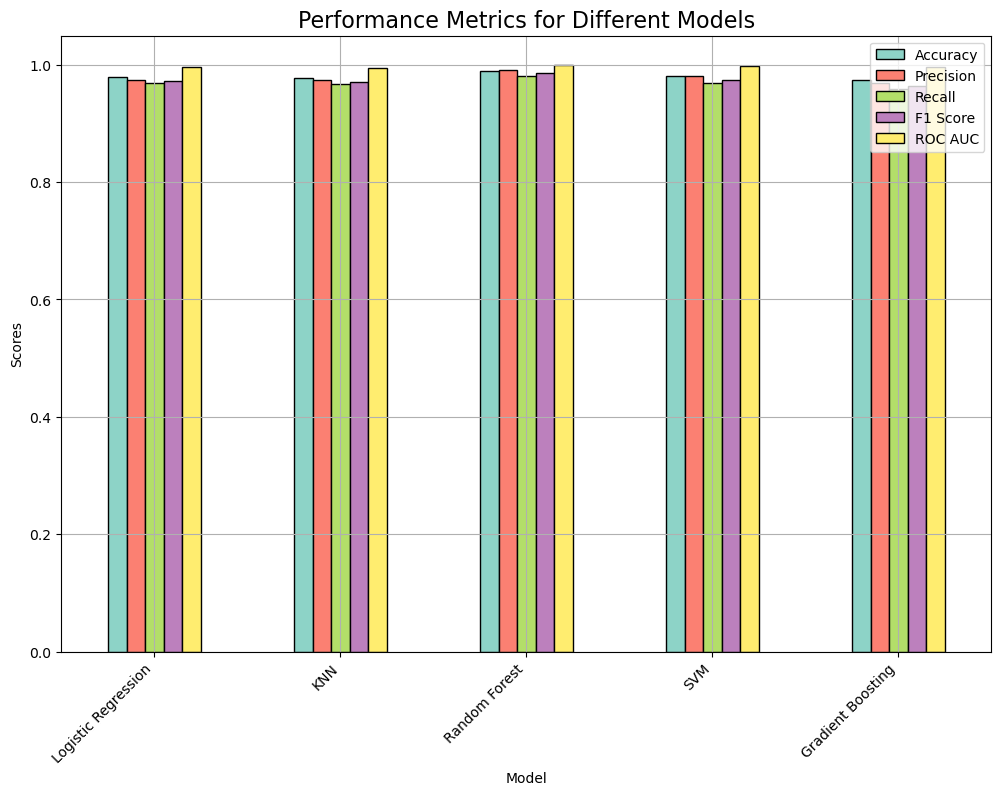

In [15]:
# Plot the performance metrics
def plot_performance_metrics(results_df):
    results_df.set_index("Model", inplace=True)
    results_df.plot(kind="bar", figsize=(12, 8), colormap="Set3", edgecolor="black")
    plt.title("Performance Metrics for Different Models", fontsize=16)
    plt.ylabel("Scores")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.show()

# Function to plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Benign', 'Malware'], yticklabels=['Benign', 'Malware'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

# Initialize the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Store the performance metrics
results = []

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    # Store the results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    })
    
    # Plot confusion matrix for each model
    plot_conf_matrix(y_test, y_pred, model_name)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results
print("\033[1mResults without SMOTE:\033[0m")
print(results_df)

# Plot the performance metrics
plot_performance_metrics(results_df)


#### 2. Modeling and Evaluation using SMOTE 

# Initialize the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Store the performance metrics
results = []

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    # Store the results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    })
    
    # Plot confusion matrix for each model
    plot_conf_matrix(y_test, y_pred, model_name)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results
print("\033[1mResults without SMOTE:\033[0m")
print(results_df)

# Plot the performance metrics
plot_performance_metrics(results_df)


Best Overall Performance: The Random Forest model has the highest accuracy (98.77%) and precision (98.73%). It also achieves an impressive F1 score (98.33%) and the highest ROC AUC (99.94%), indicating it has a strong ability to discriminate between classes.

#### 3. Classification report of best model

In [17]:
best_model = 'Random Forest'  
print(classification_report(y_test, models[best_model].predict(X_test)))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1896
           1       0.99      0.98      0.98      1111

    accuracy                           0.99      3007
   macro avg       0.99      0.99      0.99      3007
weighted avg       0.99      0.99      0.99      3007



#### 4. Detect overfitting using the ROC AUC

In [18]:
# Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_test = rf_model.predict(X_test)
# Get predicted probabilities for ROC AUC
y_pred_proba_test = rf_model.predict_proba(X_test)[:, 1]  

# Make predictions on the training set
y_pred_train = rf_model.predict(X_train_resampled)
# Get predicted probabilities for ROC AUC
y_pred_proba_train = rf_model.predict_proba(X_train_resampled)[:, 1]  

# Calculate ROC AUC for the test set
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculate ROC AUC for the training set
roc_auc_train = roc_auc_score(y_train_resampled, y_pred_proba_train)

# Output the results
print(f"Training Set ROC AUC: {roc_auc_train:.4f}")
print(f"Test Set ROC AUC: {roc_auc_test:.4f}")




Training Set ROC AUC: 0.9998
Test Set ROC AUC: 0.9994


Compared training and test ROC AUC scores to detect overfitting. ROC AUC measures a model's ability to distinguish between classes, with higher scores indicating better classification performance. To detect overfitting, you compare the ROC AUC of the model on the training set and test set. If the training ROC AUC is significantly higher than the test ROC AUC, it suggests the model has learned patterns specific to the training data but fails to generalize to new, unseen data. A large difference between these scores is a sign of potential overfitting. There is not a large difference between these scores.  

#### 5. Feature Impotance (Random Forest)

Top Features Based on Random Forest Importances:
                         Feature  Importance
6                       SEND_SMS    0.071561
4              ServiceConnection    0.054673
3                attachInterface    0.048983
13              READ_PHONE_STATE    0.048360
2                    bindService    0.037462
1             onServiceConnected    0.037040
12  android.telephony.SmsManager    0.034592
5              android.os.Binder    0.030056
68  TelephonyManager.getDeviceId    0.028744
0                       transact    0.025880


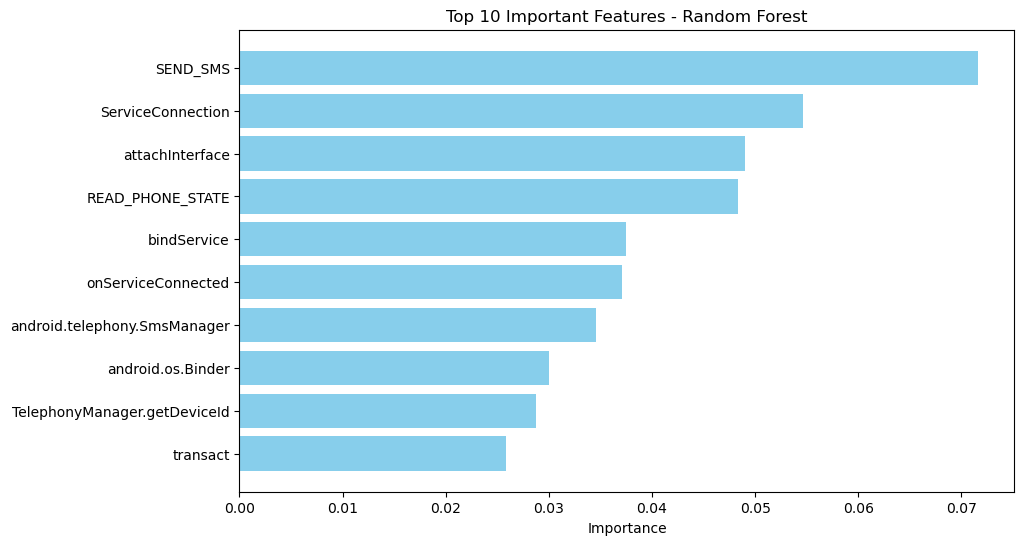

In [19]:
## Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_resampled, y_train_resampled)

# Get feature importances from Random Forest
feature_importances = rf_model.feature_importances_

# Convert the feature importances into a DataFrame for better visualization
importances_df = pd.DataFrame({
    "Feature": X_train_resampled.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Display the top features
print("\033[1mTop Features Based on Random Forest Importances:\033[0m")
print(importances_df.head(10))

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
plt.title("Top 10 Important Features - Random Forest")
plt.barh(importances_df["Feature"].head(10), importances_df["Importance"].head(10), color="skyblue")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()




Feature Importance (Random Forest) provides global interpretability. It tells you which features are most important across all the predictions of your model. This is useful for understanding general model behavior.

### Part 8: XAI 

C:\Users\caela\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\caela\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Predicted class for the chosen sample: 0


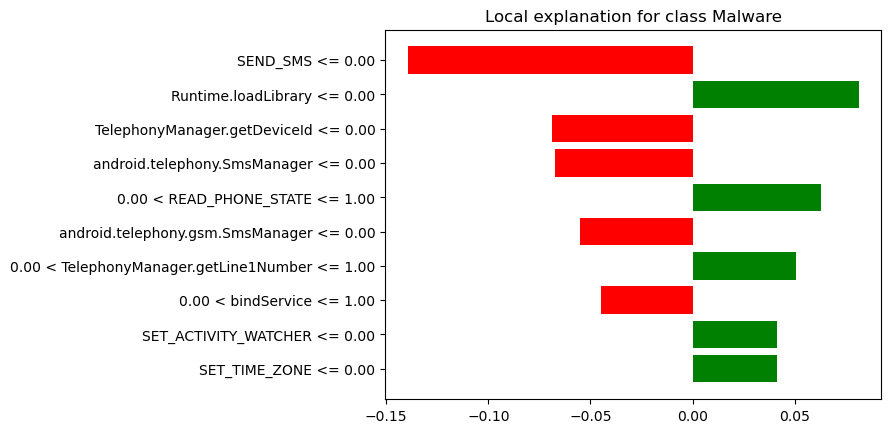

Real label for the chosen sample: 0
The LIME-explained prediction is correct!


In [20]:
# Initialize the LIME explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_resampled),  # Use the resampled training data
    feature_names=X_train_resampled.columns.tolist(),
    class_names=['Benign', 'Malware'],  # Adjust based on your class labels
    mode='classification'
)

# Choose a random sample from the test set to explain
i = np.random.randint(0, X_test.shape[0])
sample = X_test.iloc[i].values.reshape(1, -1)

# Get the prediction for the sample
predicted_class = rf_model.predict(sample)[0]
print(f"Predicted class for the chosen sample: {predicted_class}")

# Explain the prediction using LIME
exp = explainer.explain_instance(
    data_row=sample.flatten(),
    predict_fn=rf_model.predict_proba,  # Use probability predictions for LIME
    num_features=10  # Number of top features to display
)

# Display the explanation as a chart
exp.show_in_notebook(show_table=True, show_all=False)

# If you want to plot the results
exp.as_pyplot_figure()
plt.show()

# Get the real label for the chosen sample
real_label = y_test.iloc[i]
print(f"\033[1mReal label for the chosen sample: {real_label}\033[0m")

# Compare the prediction with the real label
if predicted_class == real_label:
    print("\033[1mThe LIME-explained prediction is correct!\033[0m")
else:
    print("\033[1mThe LIME-explained prediction is incorrect.\033[0m")

In [21]:
#Certainty 
classification_certainty = max(exp.predict_proba)
print(classification_certainty)





1.0
